## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: **Дарханов Евгений Владленович**

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 24 декабря.


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 51.4MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.02MB/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.5MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.39MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

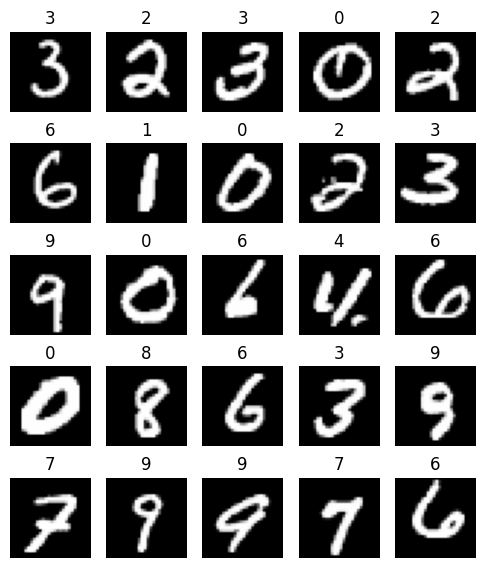

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=mean, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [7]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

Соберем все вместе, используя ReLU в качестве функции активации:

In [8]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

Посчитаем дисперсию активаций и диспресию градиентов:

In [9]:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 0.9831086993217468
forward 16.197959899902344
backward 0.0326598584651947
backward 0.17924387753009796


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Теперь попробуем использовать инициализацию He:<br>
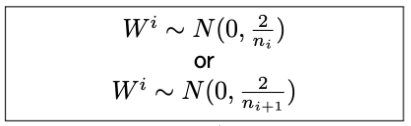

In [10]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1, 0.0, 2 / (28 * 28))
init_layer(layer_2, 0.0, 2 / 500)

In [11]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 0.9831086993217468
forward 0.04126569256186485
backward 0.0326598584651947
backward 0.0007978021167218685


#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

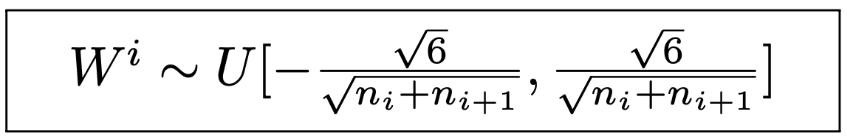

In [12]:
##### YOUR CODE HERE #####
def init_layer_xavier(layer, a, b):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(a, b)

In [13]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer_xavier(layer_1, -np.sqrt(6)/np.sqrt(28*28 + 500), np.sqrt(6)/np.sqrt(28*28 + 500))
init_layer_xavier(layer_2, -np.sqrt(6)/np.sqrt(500 + 10), np.sqrt(6)/np.sqrt(500 + 10))

In [14]:
network_XAVIER = nn.Sequential(
    layer_1,
    nn.Tanh(),
    layer_2
)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network_XAVIER(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network_XAVIER.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 0.9831086993217468
forward 0.6441153287887573
backward 0.0326598584651947
backward 0.01258355937898159


**Выводы:**

|     | He | Xavier |
| :-: | :- | :----- |
| forward  | 0.9831 | 0.9831 |
| forward  | 0.0413 | 0.6441 |
| backward  | 0.0327 | 0.0327 |
| backward  | 0.0008 | 0.0126 |

- разница между дисперсиями $n_i$ и $n_{i + 1}$ при инициализации методом **Xavier** меньше, чем
при инициализации методом **He**
- значения порядков дисперсий $n_i$ и $n_{i + 1}$ при инициализации методом **Xavier** одинаковы


## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

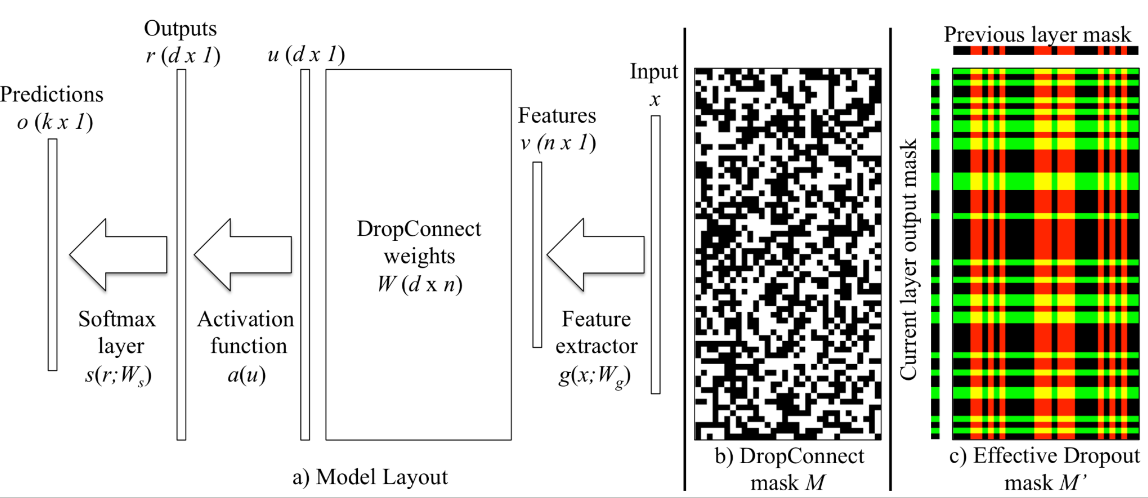

In [7]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.empty_like(self.linear.weight).bernoulli_(self.p)
        else:
            mask = torch.ones_like(self.linear.weight)

        mask.requires_grad = False
        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)

        return output


class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        mask = torch.empty(x.shape).uniform_(0, 1).type(torch.FloatTensor)
        if self.training:
            mask = torch.where(mask > self.p, 1, 0)
        else:
            mask = torch.where(mask > self.p, 1, 1 - self.p)

        return x * mask

Основа для сети, которую будем обучать:

In [8]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

In [9]:
layers_dropout = [
    ##### YOUR CODE HERE #####
    nn.Linear(196, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 10)
]

layers_dropconnect = [
    DropConnect(196, 128),
    nn.ReLU(),
    DropConnect(128, 128),
    nn.ReLU(),
    DropConnect(128, 10)
]

Обучим получившуюся сеть:

In [11]:
def train(network, optimizer, n_epochs, loss_fn):
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(n_epochs):
        network.train()
        train_loss = []
        for batch_idx, (images_train, labels_train) in enumerate(train_loader):
            optimizer.zero_grad()
            X = images_train.data
            y = labels_train.data
            output = network(X)
            loss = loss_fn(output, y)

            train_loss.append(loss.item())

            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(X), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

        history['train_loss'].append(np.mean(train_loss))

        network.eval()
        val_loss = []
        for batch_idx, (images_test, labels_test) in enumerate(test_loader):
            X = images_test.data
            y = labels_test.data
            output = network(X)
            loss = loss_fn(output, y)

            val_loss.append(loss.item())

        history['val_loss'].append(np.mean(val_loss))

        print('Test Epoch: {}\tLoss: {:.6f}'.format(
                epoch, np.mean(val_loss)))

    return history

In [12]:
network_dropout = TestNetwork(nn.Sequential(*layers_dropout))
optimizer = torch.optim.Adam(network_dropout.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()
history_dropout = train(network_dropout, optimizer, 10, loss_fn)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.304839
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.987582
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.540192
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.470621
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.420153
Test Epoch: 0	Loss: 0.340504
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.450187
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.198113
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.178420
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.251629
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.226715
Test Epoch: 1	Loss: 0.226416
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.312130
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.301633
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.302587
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.293753
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.201083
Test Epoch: 2	Loss: 0.180161
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.225307
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.345628
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.221634
Train Epoch: 3 [38400/60000 (64%)

In [13]:
network_dropconnect = TestNetwork(nn.Sequential(*layers_dropconnect))
optimizer = torch.optim.Adam(network_dropconnect.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()
history_dropconnect = train(network_dropconnect, optimizer, 10, loss_fn)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.315422
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.049850
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.116122
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.871246
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.597015
Test Epoch: 0	Loss: 1.364607
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.832763
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.403791
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.354533
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.268595
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.227719
Test Epoch: 1	Loss: 0.997104
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.226289
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.327585
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.261840
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.238018
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.230683
Test Epoch: 2	Loss: 0.782960
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.571297
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.308620
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.195335
Train Epoch: 3 [38400/60000 (64%)


#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


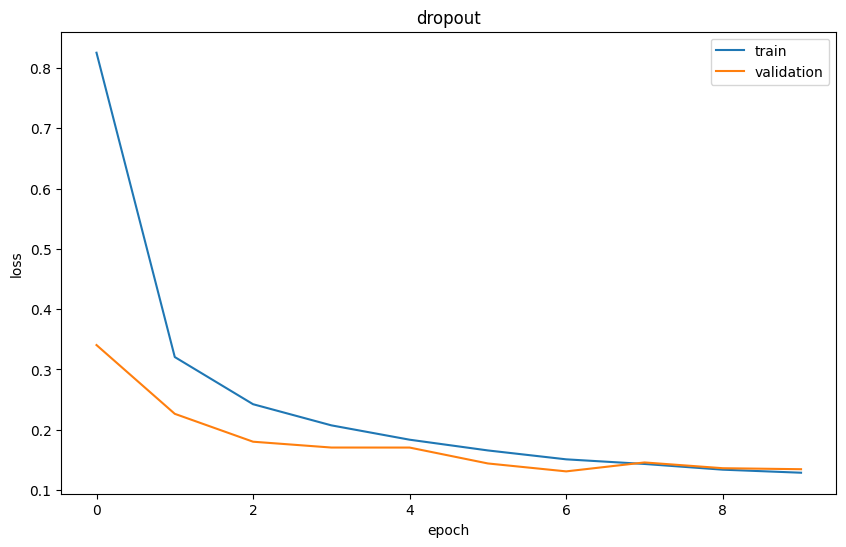

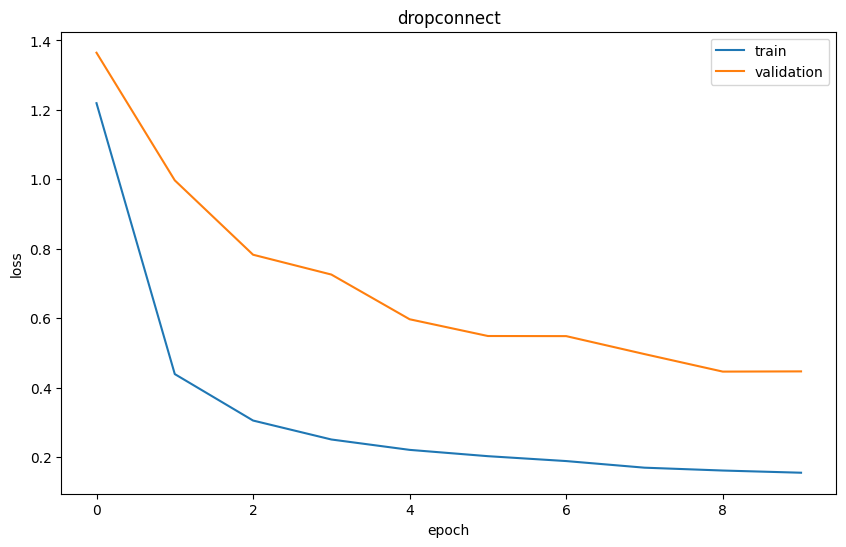

In [14]:
##### YOUR CODE HERE #####
for history, name in [(history_dropout, 'dropout'), (history_dropconnect, 'dropconnect')]:
    plt.figure(figsize=(10, 6))

    plt.plot(history['train_loss'], label='train')
    plt.plot(history['val_loss'], label='validation')

    plt.title(name)
    plt.ylabel('loss')
    plt.xlabel('epoch')

    plt.legend()

**Вывод**: dropout сходится быстрее, чем dropconnect. Значения лосса лучше у dropout

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

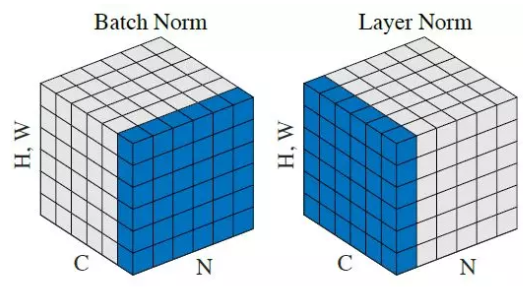

#### 3.1 Реализуйте Layer Normalization **(1 балл)**

In [15]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, dims, epsilon=1e-8):
        super().__init__()
        self.dims = dims
        self.gamma = nn.Parameter(torch.ones(dims), requires_grad=True)
        self.beta = nn.Parameter(torch.zeros(dims), requires_grad=True)
        self.epsilon = epsilon

    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        std = x.std(dim=1, keepdim=True)
        output = self.gamma * (x - mean) / (std + self.epsilon) + self.beta
        return output

#### 3.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

In [17]:
##### YOUR CODE HERE #####
layers_batchnorm = [
    nn.Linear(196, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, 10)
]

layers_layernorm = [
    nn.Linear(196, 128),
    nn.ReLU(),
    LayerNormalization(128),
    nn.Linear(128, 128),
    nn.ReLU(),
    LayerNormalization(128),
    nn.Linear(128, 10)
]

In [20]:
network_batchnorm = TestNetwork(nn.Sequential(*layers_batchnorm))
optimizer = torch.optim.Adam(network_batchnorm.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()
history_batchnorm = train(network_batchnorm, optimizer, 10, loss_fn)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.331781
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.234301
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.132813
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.066316
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.150907
Test Epoch: 0	Loss: 0.115486
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.087082
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.074887
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.029671
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.070144
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.049880
Test Epoch: 1	Loss: 0.089875
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.061578
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.056482
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.043512
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.078369
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.019587
Test Epoch: 2	Loss: 0.069661
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.076124
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.037649
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.066104
Train Epoch: 3 [38400/60000 (64%)

In [21]:
network_layernorm = TestNetwork(nn.Sequential(*layers_layernorm))
optimizer = torch.optim.Adam(network_layernorm.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()
history_layernorm = train(network_layernorm, optimizer, 10, loss_fn)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.302197
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.318162
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.245673
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.209968
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.109835
Test Epoch: 0	Loss: 0.122645
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.115017
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.090424
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.075649
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.078134
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.091830
Test Epoch: 1	Loss: 0.090217
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.140038
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.086043
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.113116
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.162821
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.049288
Test Epoch: 2	Loss: 0.079645
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.092826
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.095148
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.046689
Train Epoch: 3 [38400/60000 (64%)

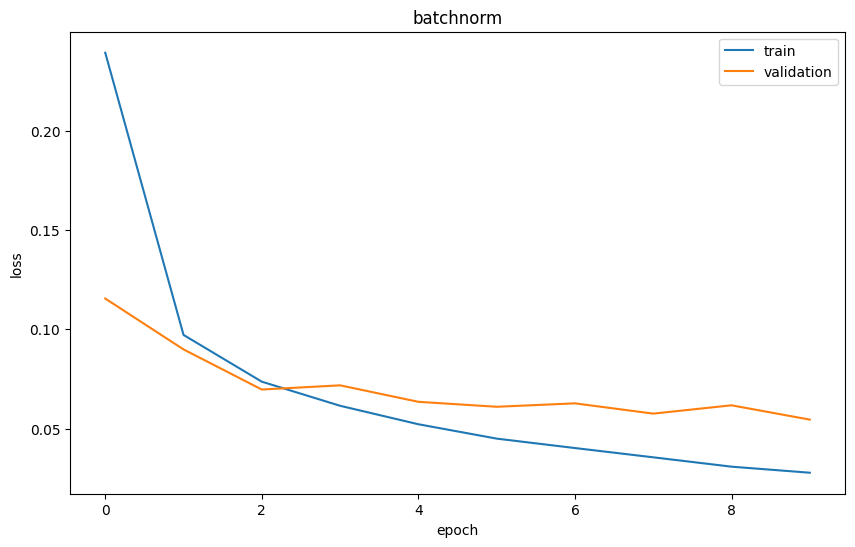

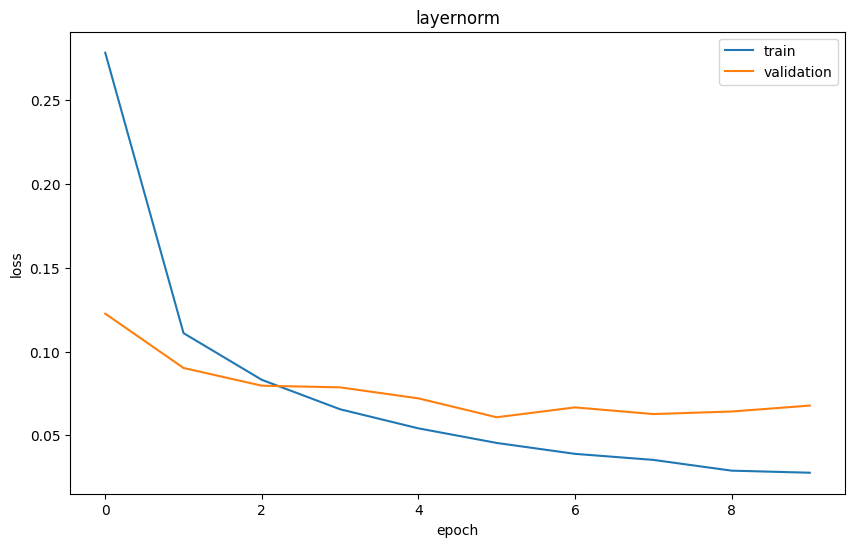

In [22]:
for history, name in [(history_batchnorm, 'batchnorm'), (history_layernorm, 'layernorm')]:
    plt.figure(figsize=(10, 6))

    plt.plot(history['train_loss'], label='train')
    plt.plot(history['val_loss'], label='validation')

    plt.title(name)
    plt.ylabel('loss')
    plt.xlabel('epoch')

    plt.legend()

**Вывод**: по форме графиков результаты применения **batchnorm** и **layernorm** отличаются несильно, однако у **batchnorm** значения ошибок меньше